# Calibrate exact tellurics from A0V

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D

import seaborn as sns

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Version 1.9.1.post3 of PyTorch does not offer erfcx, defaulting to unstable...


In [2]:
device

'cpu'

## Get Real data with unknown signals

In [3]:
from muler.hpf import HPFSpectrum

Select an A0V standard star

LFC calibrator:   
#/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T082120_v1.0_0005.spectra.fits

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

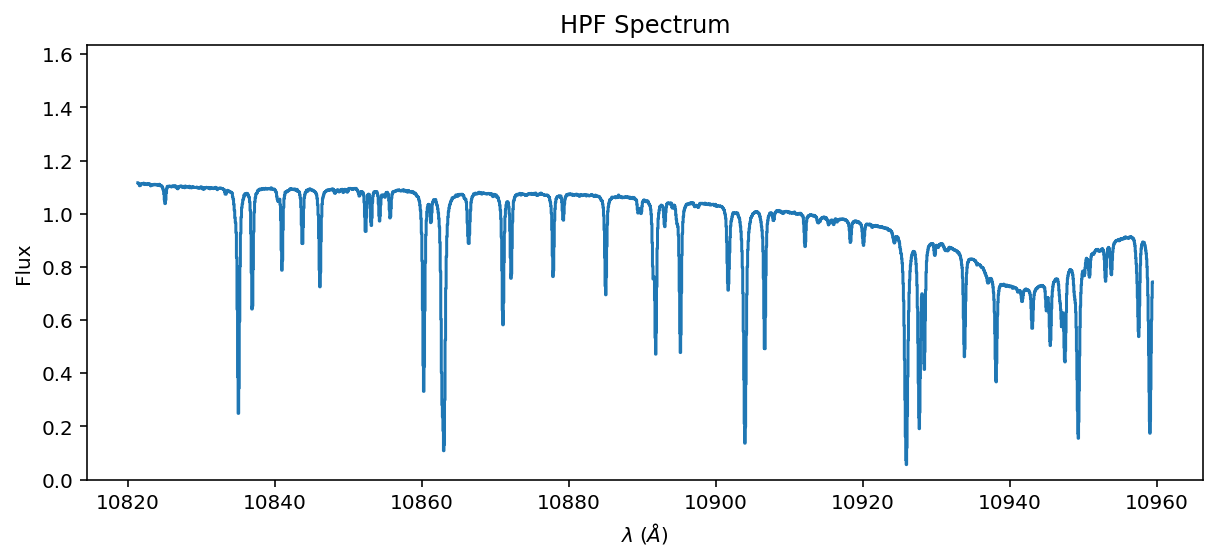

In [4]:
spec = HPFSpectrum(file='/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T033933_v1.0_0001.spectra.fits')

spec = spec.sky_subtract().trim_edges((10, 2048)).remove_nans().deblaze().normalize()
spec.plot()

In [5]:
spec.meta['header']['OBJECT']

'HR4828_tell_std'

In [6]:
from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid

In [7]:
#grid = PHOENIXGrid(teff_range=(9_000, 11_000), logg_range=(3,5), Z_range=(-0.5, 0.5), wl_lo=10770, wl_hi=11010)

In [8]:
vsini_init = 118.80
RV_init = 41.9
teff_init=9_400
logg_init=4.0

In [9]:
template = PHOENIXSpectrum(teff=teff_init, logg=logg_init, wl_lo=10770, wl_hi=11010)\
            .rotationally_broaden(vsini_init)\
            .rv_shift(RV_init)\
            .normalize()

In [10]:
scalar = np.percentile(spec.flux, 99)
spec = spec.divide(scalar, handle_meta='ff')
scalar = np.percentile(template.flux, 99)
template = template.divide(scalar, handle_meta='ff')

In [11]:
template = template.resample(spec)

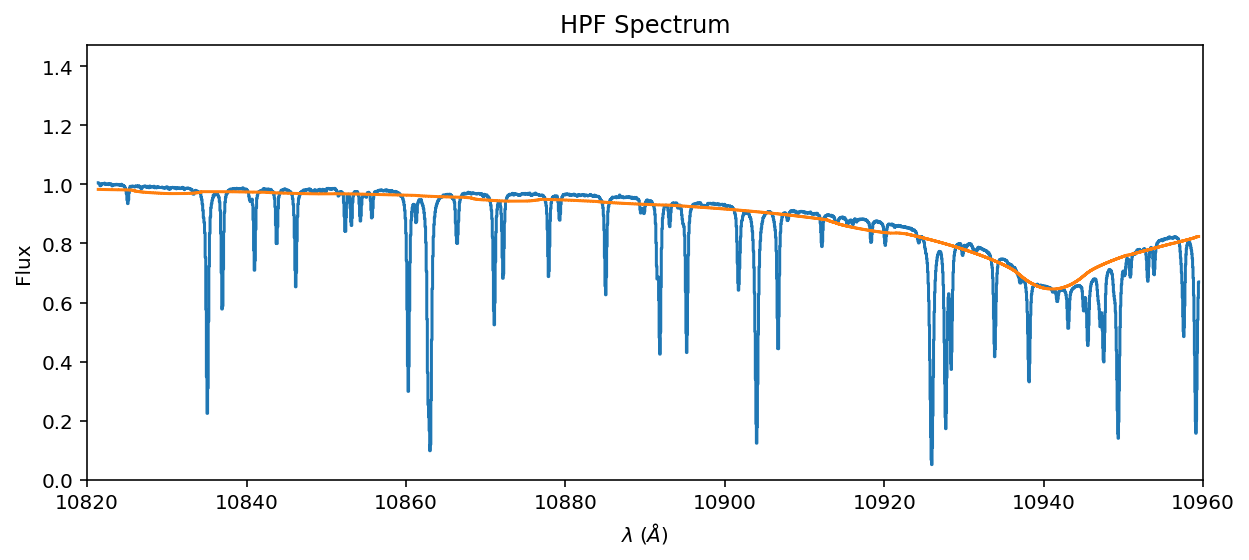

In [12]:
ax = spec.plot()
template.plot(ax=ax)
ax.set_xlim(10820, 10960);

In [13]:
spectrum = spec

In [14]:
spectrum.bin_edges

<Quantity [10821.35515741, 10821.43418663, 10821.51321086, ...,
           10959.3483403 , 10959.40456759, 10959.46078881] Angstrom>

In [15]:
guess_sigma = 0.1
guess_gamma = 0.05

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [16]:
from scipy.signal import find_peaks

In [17]:
peaks = find_peaks(1-spectrum.flux.value, distance=10, prominence=0.01)[0]

In [18]:
peak_coords = spectrum.wavelength.value[peaks]

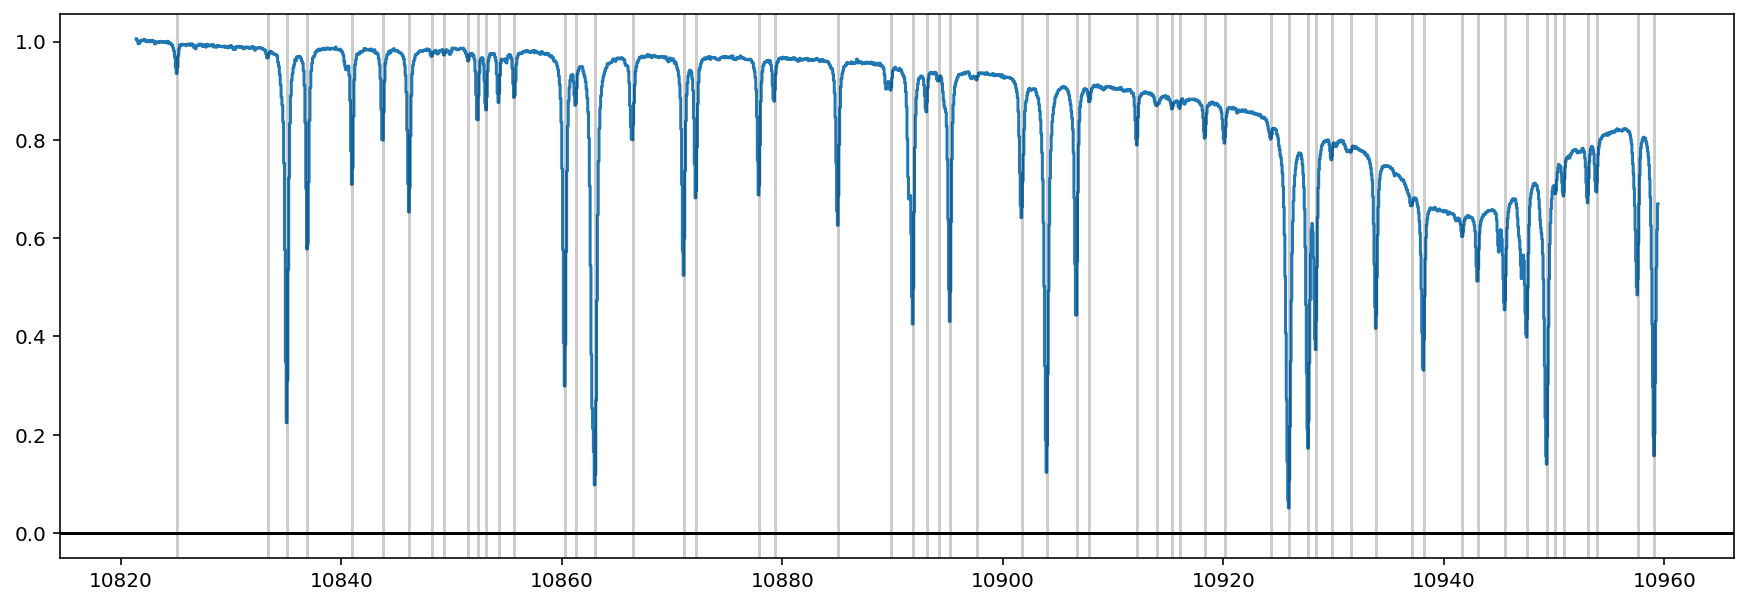

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.step(spectrum.wavelength, spectrum.flux)

for xv in peak_coords:
    ax.axvline(xv, linestyle='solid', alpha=0.2, color='k')
    
ax.axhline(0.0, color='k');

We have detected all the spectral lines

In [20]:
wl_lo = 10820-30.0
wl_hi = 10960+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

## Model the lines with blasé

In [25]:
from gollum.telluric import TelFitSpectrum

In [26]:
from blase.emulator import SparseLogEmissionEmulator

### Guess and check

In [27]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [28]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()

In [29]:
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

In [30]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`

In [31]:
telluric_lnflux[telluric_lnflux < -15] = -15

In [32]:
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux,
                             wing_cut_pixels=6000, prominence=0.01, device=device)

/Users/mag3842/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 62 spectral lines


In [33]:
with torch.no_grad():
    telluric_pre = emulator.forward().cpu().numpy()

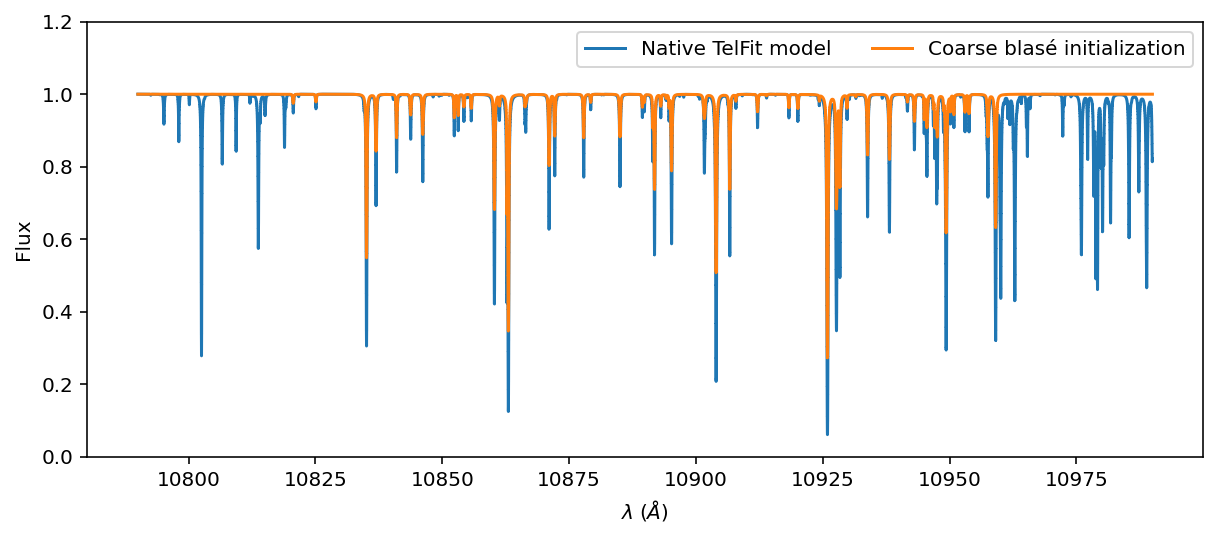

In [35]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_pre, label='Coarse blasé initialization')
ax.legend(loc='upper right', ncol=2);

In [44]:
emulator.lam_centers.requires_grad = True
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

In [45]:
emulator.optimize(epochs=100, LR=0.05)

Training Loss: 0.00000500: 100%|██████████████| 100/100 [00:52<00:00,  1.91it/s]


In [46]:
with torch.no_grad():
    telluric_post = emulator.forward().cpu().numpy()

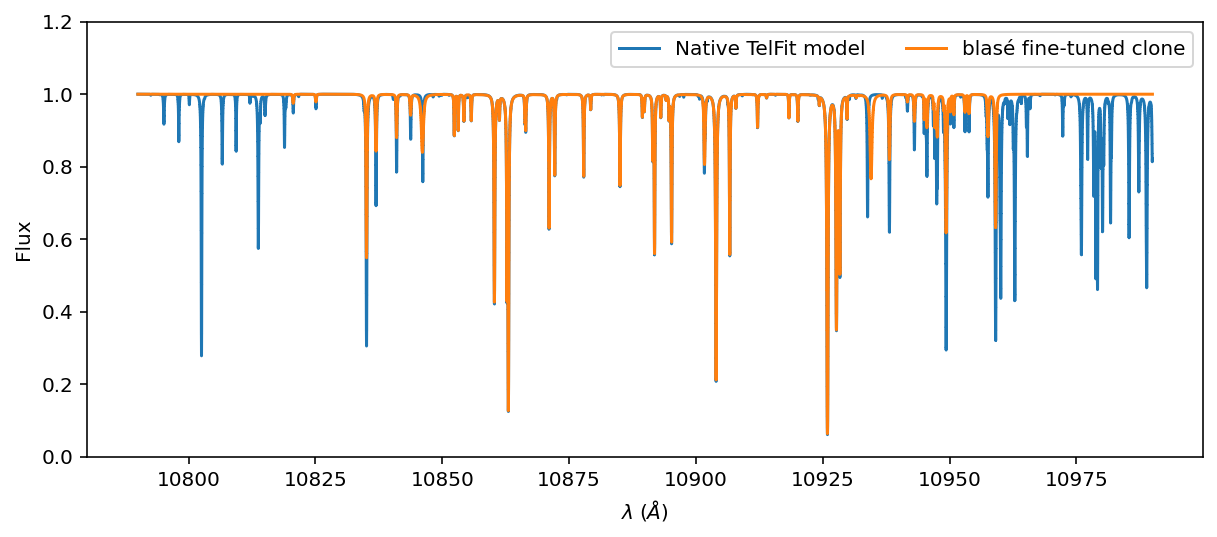

In [47]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_post, label='blasé fine-tuned clone')
ax.legend(loc='upper right', ncol=2);

#### Instrumental model

In [42]:
instrumental_model = InstrumentalModel(spectrum.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [43]:
#instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [32]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [33]:
data_target = torch.tensor(
    spectrum.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    spectrum.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [34]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [35]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = True
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = False
emission_model.b_coeff.requires_grad = False
emission_model.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = False
instrumental_model.linear_model.weight.requires_grad = False
instrumental_model.linear_model.bias.requires_grad = False

In [36]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters()))

In [37]:
optimizer = optim.Adam(tuning_params,0.05,amsgrad=True)         

In [38]:
n_epochs = 1000
losses = []

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [39]:
#per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

In [40]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    detector_flux = instrumental_model.resample_to_data(flux)
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00008538: 100%|████████████| 1000/1000 [00:45<00:00, 22.18it/s]


### Spot check the transfer-learned joint model

In [41]:
residual = spectrum.flux - detector_flux.detach().cpu().numpy()

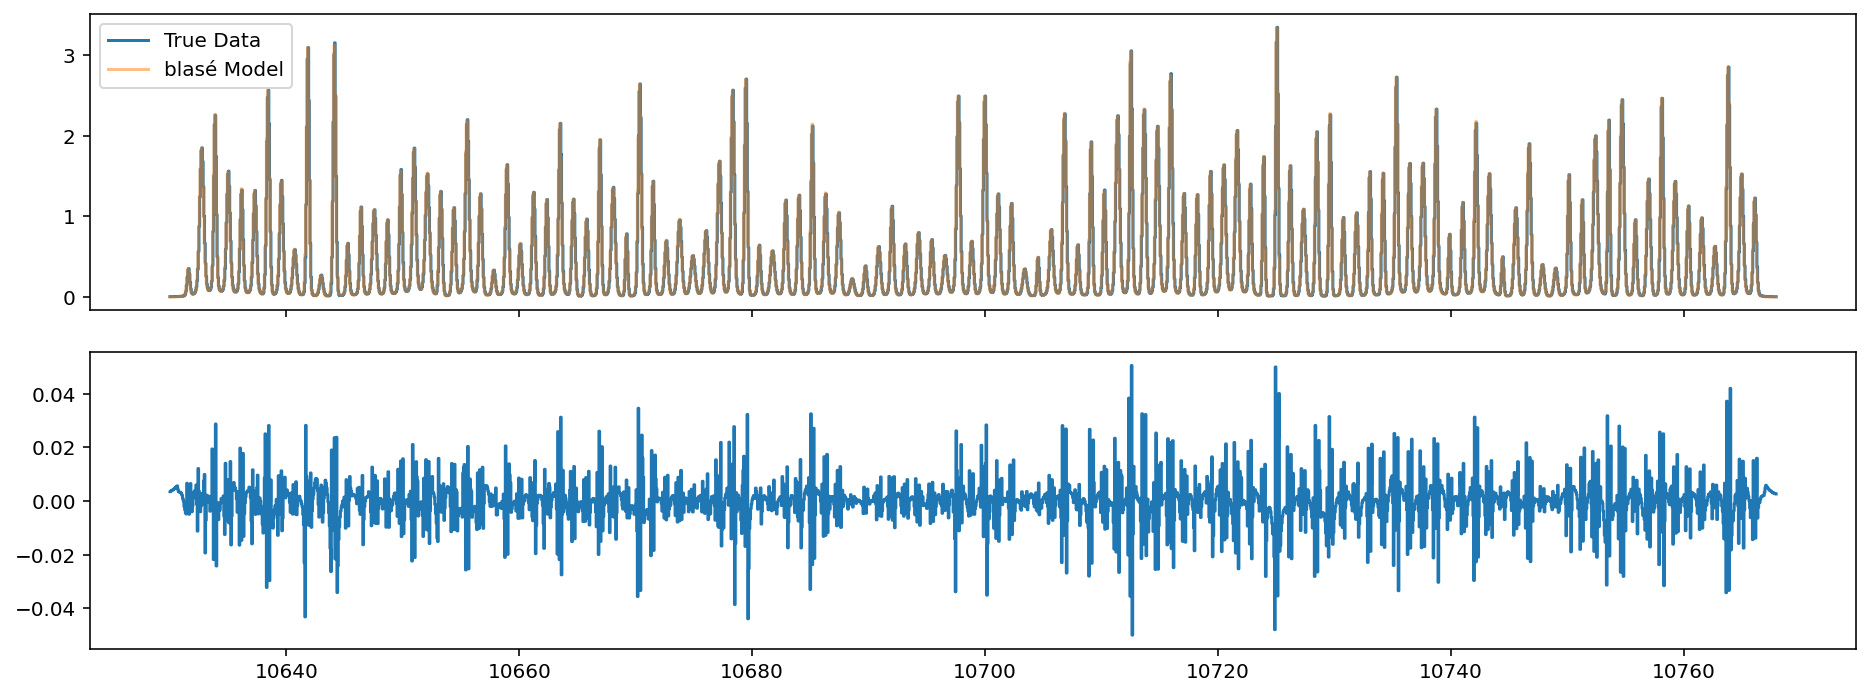

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.step(spectrum.wavelength,residual)
ax1.legend();

Hooray! We match the data pretty well!

In [43]:
np.std(residual)

<Quantity 0.00923987>

(10690.0, 10710.0)

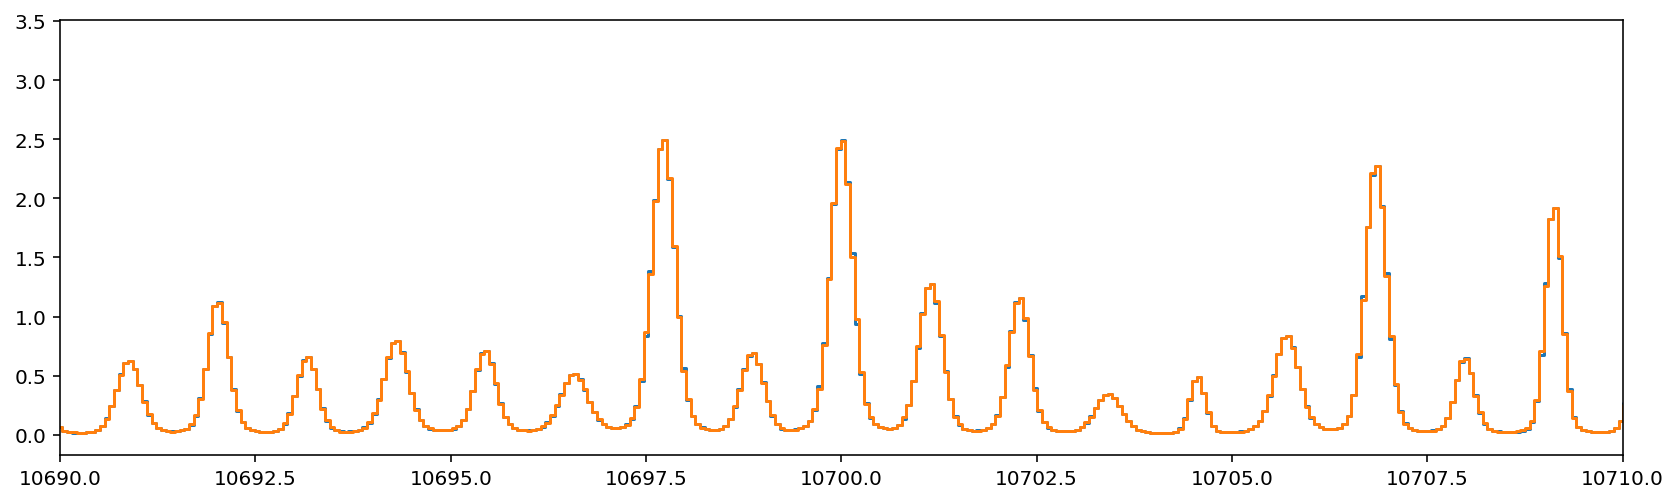

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10690, 10710)

Looks great, albeit not perfect-- we are resampling spectra, which should have an effect here...

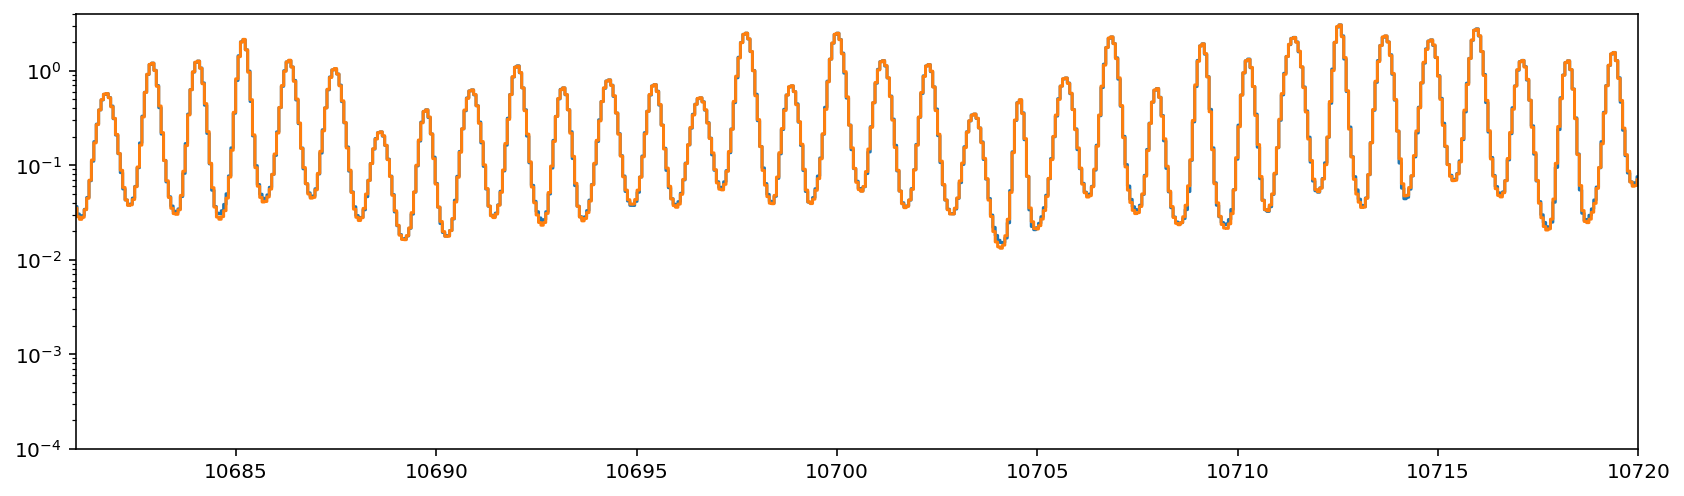

In [45]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10681, 10720)
ax.set_ylim(1e-4, 4)
plt.yscale('log')

A ha! Our Voigt profile drops off too quickly--- we need heavier tails!  Something is wrong in our prescription...

### Inspect the individual stellar and telluric components

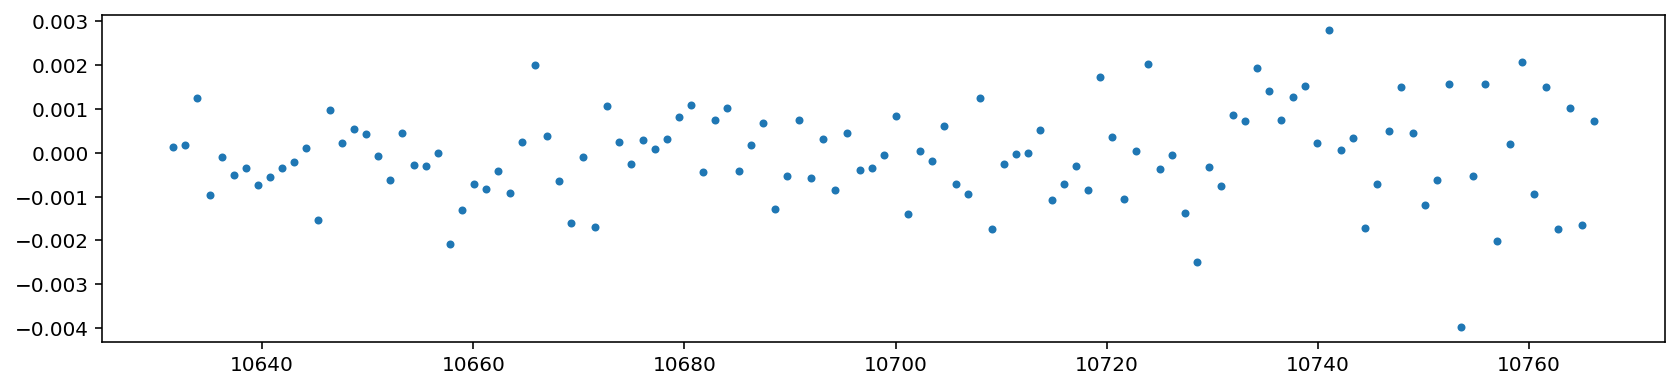

In [46]:
fig, ax = plt.subplots(figsize=(14,3))
plt.plot(true_lam_centers, emission_model.lam_centers.detach()-true_lam_centers, '.')

In [53]:
from astropy import constants as const

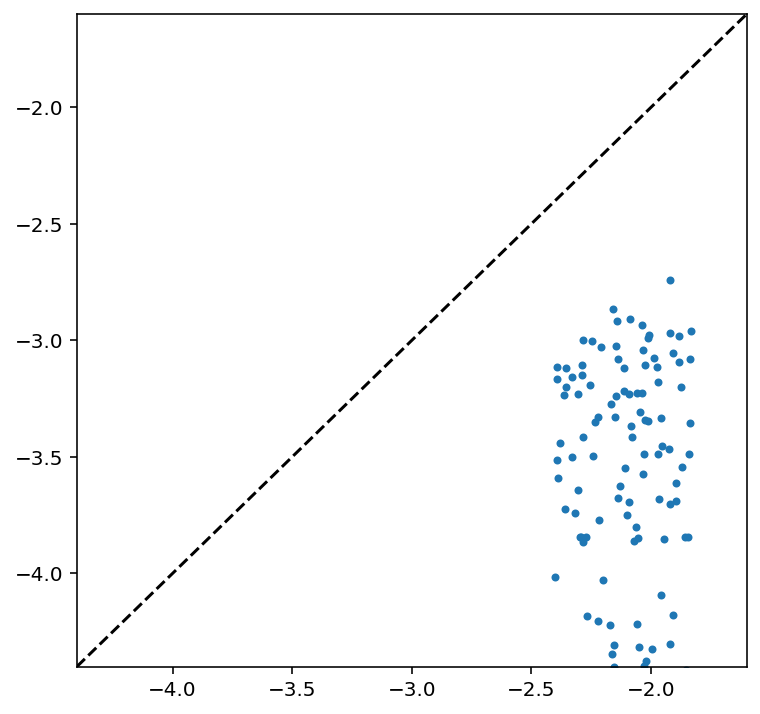

In [47]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_sigmas), emission_model.sigma_widths.detach(), '.')
ax.set_xlim(-4.4, -1.6)
ax.set_ylim(-4.4, -1.6)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k')

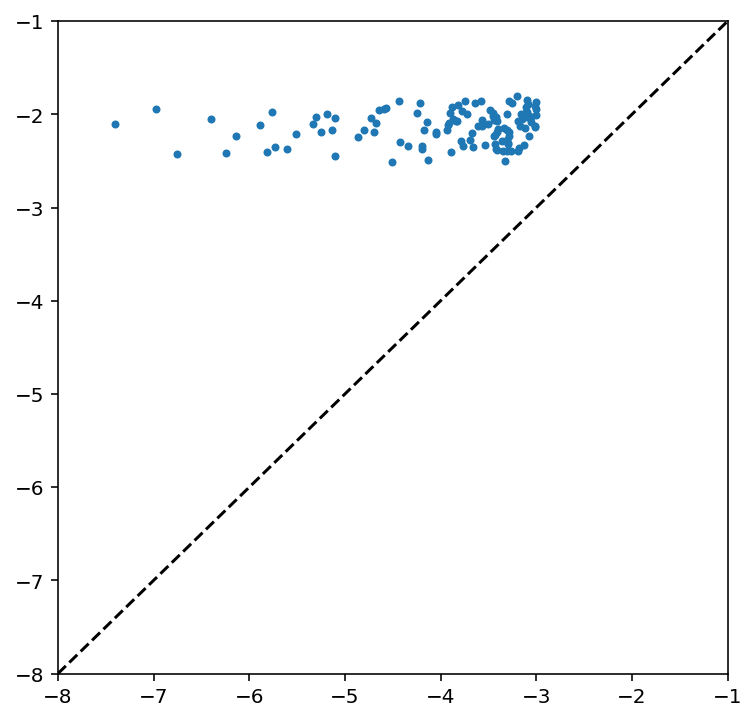

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_gammas), emission_model.gamma_widths.detach(), '.')
ax.set_xlim(-8, -1)
ax.set_ylim(-8, -1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k');

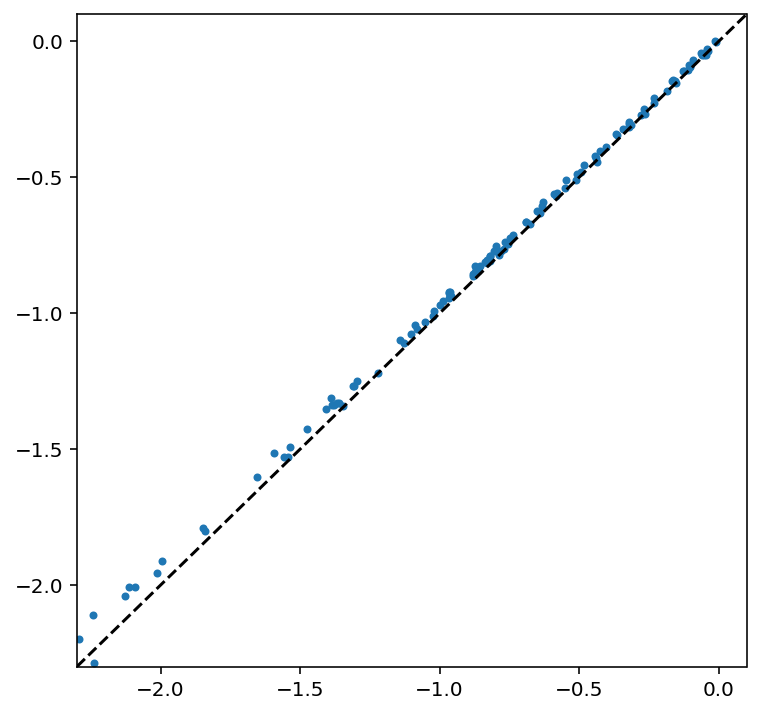

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_amplitudes), emission_model.amplitudes.detach(), '.')
ax.set_xlim(-2.3, 0.1)
ax.set_ylim(-2.3, 0.1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k');

In [50]:
retrieved_sigmas = torch.exp(emission_model.sigma_widths.detach()).numpy()
retrieved_gammas = torch.exp(emission_model.gamma_widths.detach()).numpy()
retrieved_amps = torch.exp(emission_model.amplitudes.detach()).numpy()

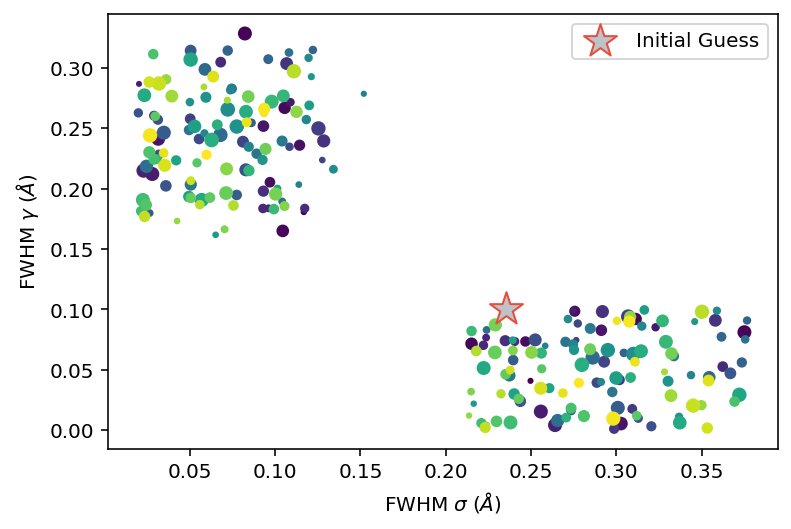

In [51]:
plt.scatter(2.355*true_sigmas, 2*true_gammas, s=true_amplitudes*40, c=true_lam_centers)

plt.scatter(2.355*retrieved_sigmas, 2*retrieved_gammas, s=retrieved_amps*40, c=true_lam_centers)

plt.xlabel('FWHM $\sigma \; (\AA)$')
plt.ylabel('FWHM $\gamma \; (\AA)$')
plt.scatter([2.355*guess_sigma], [2*guess_gamma], marker='*', s=300, color='#bdc3c7', ec='#e74c3c', label='Initial Guess')
plt.legend();

## Insights

Weird! We find an incompatible locus of posterior parameters--- why?

We have nearly-degenerate families of solutions: you can turn up $\sigma$ and down $\gamma$ (or vice versa) and get about the same answer.  We could/should have instead fit for FWHM and then a shape parameter $(\in 0-1)$.  With that parameterization we would get an exact FWHM constraint, but only a weak constraint on the shape parameter. We may want to do that moving forward!


Even still, it might seem odd that a noise-free spectrum doesn't converge to the exact input, after all there is zero noise added to the input.  Here are some reasons why we still don't get the "right answer":


- We chose Voigt wings that are weak and only manifest near zero flux, where other factors may dominate.  
- Pixel resampling could matter at this level
- The approximations in our implementaiton of the ExoJAX HJERT may be inexact
- The wingcut could matter
- A bug somewhere
- Initial guess matters